# Finer Mesh and Stress Calculation in the 2D TO Algorithm
Conceptualised and developed by erin.yu22@imperial.ac.uk, sasha.halsey20@imperial.ac.uk and a.panesar@imperial.ac.uk

-------------------
### Objectives of this lab
1) Run Compliance TO based on finer discretisation
2) Calculate mechanical stress field

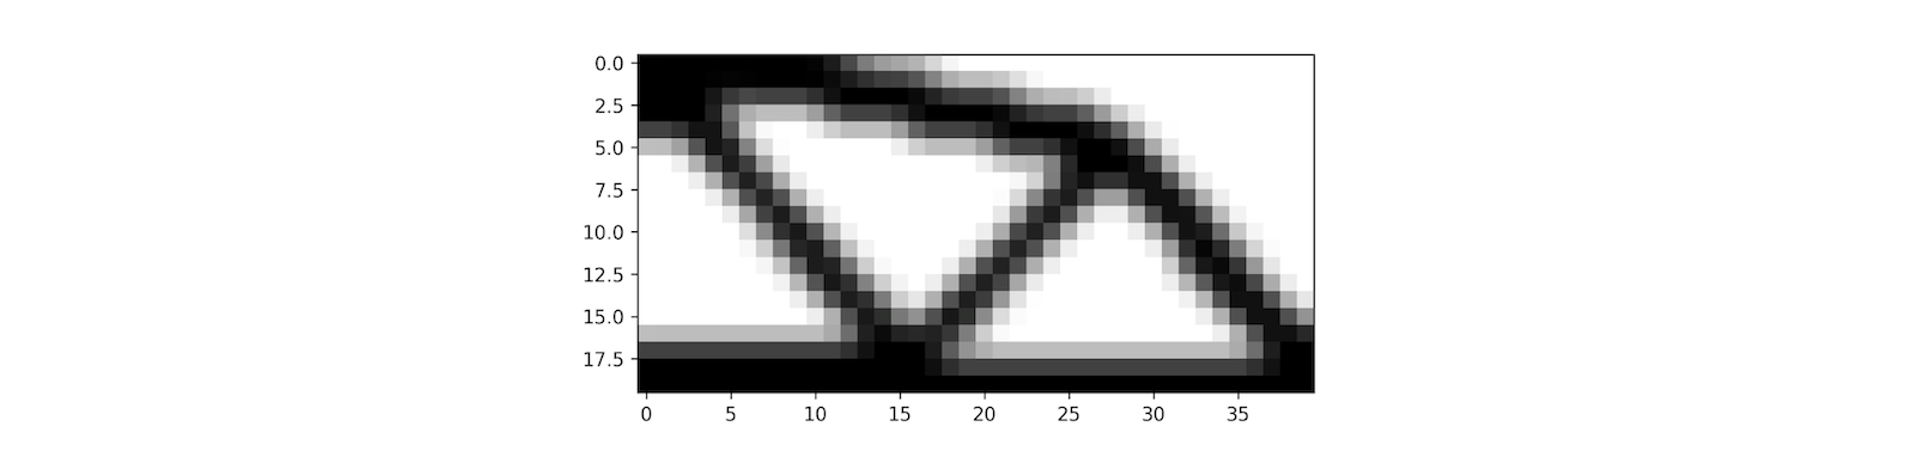

####  Import library

Run the cell below to import necessarry python libraries for this lab.

If you encounter an error, identify the unsuccessfully-installed library name by reading the error message, cut the corresponding pip install statement (without '#' symbol) into a separate cell and run it. Upon running the pip install cell, then restart the kernel and run the (default) import library cell again. Raise hand during the lab or email erin.yu22@imperial.ac.uk if you cannot resolve the issue.

In [ ]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from matplotlib import colors
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve

import numpy as np
from functions import lk, FE_solve, compliance_and_sensitivity, oc, make_edofMat

# Problem setup
nelx, nely = 60, 30
volfrac = 0.4
penal = 3
Emin, Emax = 1e-9, 1.0
nu = 0.3

KE = lk(Emax, nu)
edofMat = make_edofMat(nelx, nely)

# Filtering (dummy minimal)
H = np.eye(nelx*nely)
Hs = np.ones(nelx*nely)

# Density field
x = volfrac * np.ones(nelx*nely)
dv = np.ones_like(x)


# Boundary conditions
ndof = 2 * (nelx+1) * (nely+1)

# BC's and support
dofs=np.arange(2*(nelx+1)*(nely+1))
fixed=np.union1d(dofs[0:2*(nely+1):2],np.array([2*(nelx+1)*(nely+1)-1]))
free=np.setdiff1d(dofs,fixed)

# Solution and RHS vectors
f=np.zeros((ndof,1))
u=np.zeros((ndof,1))
    
# Set load
f[1,0]=-1

# Optimisation loop
for it in range(10):
    U = FE_solve(nelx, nely, x, penal, KE, free, f, Emin, Emax, edofMat)
    obj, dc, ce = compliance_and_sensitivity(U, KE, penal, x, Emin, Emax, H, Hs, edofMat)
    x, g = oc(nelx, nely, x, volfrac, dc, dv, 0)


# Stress computation
# 3x3 plane stress stiffness
D = (Emax/(1-nu**2)) * np.array([
    [1,   nu,       0],
    [nu,  1,        0],
    [0,   0,  (1-nu)/2]])

# B matrix at element center
B = 0.25 * np.array([
    [-1,0, 1,0, 1,0, -1,0],
    [0,-1, 0,-1, 0,1, 0,1],
    [-1,-1, -1,1, 1,1, 1,-1]])

nel = nelx*nely
sigma_elem = np.zeros((nel,3))
sigma_vm = np.zeros(nel)

for el in range(nel):
    edofs = edofMat[el]
    u_e = U[edofs]

    eps = B @ u_e
    sig = D @ eps

    sigma_elem[el,:] = sig

    sx, sy, txy = sig
    sigma_vm[el] = np.sqrt(sx*sx - sx*sy + sy*sy + 3*txy*txy)

sigma_vm_grid = sigma_vm.reshape((nelx,nely)).T

print("Von Mises stress grid:\n")
print(np.round(sigma_vm_grid,2))

-----------
# 1.1) Input parameters

We will use the same approach as before:

You are able to discritise the design domain by defining the number of elements in x and y direction (nelx, nely). More elements will lead to higher resolution but also increasing computational time. You can define a target volume fraction of the final topology relative to the entire design domain (volfrac). In SIMP approach, intermediate density will be penalised (penal). To avoid checkboard pattern, filtering scheme will be applied (rmin).

This time, YOU must discretise the mesh:

In [ ]:
nelx = 30
nely = 20
nel = nelx * nely
volfrac = 0.3
penal = 3.0
rmin = 1.0

Emin = 1e-9
Emax = 1.0
nu = 0.3

# plotting functions
def plot_density(xPhys):
    fig, ax = plt.subplots(figsize=(5,3))
    im = ax.imshow(-xPhys.reshape((nelx, nely)).T, cmap='gray', interpolation='none',
                   norm=colors.Normalize(vmin=-1, vmax=0), origin='lower')
    ax.set_xticks([]); ax.set_yticks([])
    plt.title("Density")
    plt.show()

Number of elements in the x-direction: 3
Number of elements in the y-direction: 2
Targeted volume fraction: 0.3
Penalty: 3
Filter radius: 1


# 1.2) Import FE Functions
These are from Lab (a), cleaned up and call-able, so you don't have to worry about them.

Note: if you change anything in functions.py, you will have to re-start the kernel before you re-run 

In [ ]:
from functions import lk, FE_solve, compliance_and_sensitivity, oc

# 1.3) Compute Element Stiffness Matrix, Build edofMat and Define Boundary Conditions

In [ ]:
KE = lk(E=1.0, nu=nu)
ndof = 2 * (nelx + 1) * (nely + 1)

edofMat = np.zeros((nel, 8), dtype=int)
for elx in range(nelx):
    for ely in range(nely):
        el = ely + elx*nely
        n1 = (nely+1)*elx + ely
        n2 = (nely+1)*(elx+1) + ely
        edofMat[el, :] = np.array([
            2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3,
            2*n2,   2*n2+1, 2*n1,   2*n1+1
        ])
dofs = np.arange(ndof)
fixed = np.union1d(dofs[0:2*(nely+1):2],
                   np.array([2*(nelx+1)*(nely+1)-1]))
free = np.setdiff1d(dofs, fixed)

# Boundary conditions
f = np.zeros(ndof)
f[1] = -1.0

# 1.4) Build Density Filter

In [ ]:
nfilter = int(nelx*nely*((2*(np.ceil(rmin)-1)+1)**2))
iH = np.zeros(nfilter)
jH = np.zeros(nfilter)
sH = np.zeros(nfilter)
cc = 0

for i in range(nelx):
    for j in range(nely):
        row = i*nely + j
        kk1 = int(max(i - (np.ceil(rmin)-1), 0))
        kk2 = int(min(i + np.ceil(rmin), nelx))
        ll1 = int(max(j - (np.ceil(rmin)-1), 0))
        ll2 = int(min(j + np.ceil(rmin), nely))
        for k in range(kk1, kk2):
            for l in range(ll1, ll2):
                col = k*nely + l
                fac = rmin - np.sqrt((i-k)**2 + (j-l)**2)
                iH[cc] = row
                jH[cc] = col
                sH[cc] = max(0.0, fac)
                cc += 1

H = coo_matrix((sH, (iH, jH)), shape=(nel, nel)).tocsc()
Hs = H.sum(1)

# 1.5) Initialise the Design

In [ ]:
x = volfrac * np.ones(nel, dtype=float)
xold = x.copy()
xPhys = x.copy()
dv = np.ones(nel)
ce = np.ones(nel)

g=0 # must be initialised to use the NGuyen/Paulino OC approach
dc=np.zeros((nely,nelx), dtype=float)

# Set loop counter and gradient vectors 
loop=0
change=1


Initialise design variables to the target volume fraction:
[[0.3 0.3 0.3]
 [0.3 0.3 0.3]]

Initialise sensitivity matrix to zeros:
[[0. 0. 0.]
 [0. 0. 0.]]


# 1.6) Loop Optimisation

In [ ]:
max_iter = 50

for it in range(max_iter):

    U = FE_solve(nelx, nely, xPhys, penal, KE, free, f,
                 Emin=Emin, Emax=Emax, edofMat=edofMat)

    obj, dc, ce = compliance_and_sensitivity(
        U, KE, penal, xPhys, Emin, Emax, H, Hs, edofMat
    )

    dv = np.asarray(H * (np.ones(nel)[:,None] / Hs))[:, 0]

    xold[:] = x
    x[:], g = oc(nelx, nely, x, volfrac, dc, dv, g)
    xPhys[:] = np.asarray(H * (x[:,None] / Hs))[:, 0]

    change = np.max(np.abs(x - xold))
    print(it, obj, change)

    if change < 1e-3:
        break

----------
# 2.1) Calculate Stress

The stress in each element is computed from
$$
\boldsymbol{\sigma} = D\,\boldsymbol{\varepsilon}
\qquad\text{with}\qquad
\boldsymbol{\varepsilon} = B\,u_e
$$

where  
- \(u_e\) is the element displacement vector,  
- \(B\) maps nodal displacements to strain,  
- \(D\) defines the constitutive relation.

### Constitutive Matrix $D$

For 2D plane-stress, the constitutive matrix is
$$
D
=
\frac{E}{1-\nu^2}
\begin{bmatrix}
1 & \nu & 0 \\
\nu & 1 & 0 \\
0 & 0 & \tfrac{1-\nu}{2}
\end{bmatrix}.
$$

### Strain–Displacement Matrix $B$

For a 4-node bilinear quadrilateral (Q4) element, the strain is
$$
\boldsymbol{\varepsilon}
=
\begin{bmatrix}
\varepsilon_{xx} \\
\varepsilon_{yy} \\
\gamma_{xy}
\end{bmatrix}
=
B\,u_e.
$$

At the element centre, the strain–displacement matrix is
$$
B
=
\frac{1}{4}
\begin{bmatrix}
-1 & 0 & 1 & 0 & 1 & 0 & -1 & 0 \\
0 & -1 & 0 & -1 & 0 & 1 & 0 & 1 \\
-1 & -1 & -1 & 1 & 1 & 1 & 1 & -1
\end{bmatrix}.
$$

The element DOF ordering matches
$$
u_e =
[u_{1x},\,u_{1y},\,u_{2x},\,u_{2y},\,u_{3x},\,u_{3y},\,u_{4x},\,u_{4y}]^T.
$$

The node positions follow:

        (4)-------(3)
         |         |
         |         |
         |         |
        (1)-------(2) 

In [ ]:
E = Emax   # or use (Emin + xPhys**penal*(Emax-Emin)) per element
D = (E/(1-nu**2)) * np.array([[1, nu, 0],
                              [nu, 1, 0],
                              [0, 0, (1-nu)/2]])

# B at element center for a bilinear quad of size 1x1 and node order:
# node_order = [bottom-left, bottom-right, top-right, top-left]
# DOF order per node = [ux, uy]
B_center = (1/4.0) * np.array([
    [-1,  0,  1,  0,  1,  0, -1,  0],   # dNx/dx approximated for unit square
    [ 0, -1,  0, -1,  0,  1,  0,  1],   # dNy/dy approximated for unit square
    [-1, -1, -1,  1,  1,  1,  1, -1]])  # shear part (mixed derivatives)

# build element node indices consistent with node numbering
# node indexing: n = (nely+1)*ix + iy  with iy in [0..nely]
def element_node_indices(elx, ely):
    n1 = (nely+1)*elx + ely            # bottom-left
    n2 = (nely+1)*(elx+1) + ely        # bottom-right
    # nodes: bottom-left, bottom-right, top-right, top-left
    return np.array([n1, n2, n2+1, n1+1], dtype=int)

In [ ]:
sigma_elem = np.zeros((nelx*nely, 3))
sigma_vm  = np.zeros(nelx*nely)

for elx in range(nelx):
    for ely in range(nely):
        e = ely + elx*nely
        nodes = element_node_indices(elx, ely)    # 4 node indices
        # build DOF ordering matching B_center: [u1x,u1y,u2x,u2y,u3x,u3y,u4x,u4y]
        dofs = np.zeros(8, dtype=int)
        for i, n in enumerate(nodes):
            dofs[2*i]   = 2*n      # ux
            dofs[2*i+1] = 2*n + 1  # uy

        u_e = u[dofs, 0]   # 8x1 element displacement vector

        # compute strain and stress
        eps_e = B_center @ u_e
        sig_e = D @ eps_e

        sigma_elem[e, :] = sig_e
        # von Mises
        sx, sy, txy = sig_e
        sigma_vm[e] = np.sqrt(sx**2 - sx*sy + sy**2 + 3*(txy**2))

# print in nice grid form (nely rows x nelx cols). note: arr earlier was transposed
sigma_vm_grid = sigma_vm.reshape((nelx, nely)).T   # shape (nely, nelx)
sigma_x_grid  = sigma_elem[:,0].reshape((nelx, nely)).T
sigma_y_grid  = sigma_elem[:,1].reshape((nelx, nely)).T

print("Element sigma (σx, σy, τxy) for each element (nely x nelx):\n")
for j in range(nely):
    for i in range(nelx):
        idx = j + i*nely
        print(f"e({i},{j}):", np.round(sigma_elem[idx],4), end="   ")
    print()

print("\nVon Mises stress (nely x nelx):\n", np.round(sigma_vm_grid,4))

In [ ]:
# Initialise plot
fig, ax = plt.subplots(figsize=(4, 3))
im = ax.imshow(sigma_vm_grid, cmap="inferno", interpolation="none", origin="lower",)

# Add a color bar
cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.1)
cbar.set_label("Von Mises stress")
# hide ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Stress distribution")
# plot
plt.tight_layout()
plt.show()

# 2.3) Optional: Calculate stress and distortion due to temperature change
### Thermal Strain

For a temperature change $\color{lightblue}{\Delta T = T - T_0}$ and thermal expansion coefficient $\color{lightblue}{\alpha}$:
$$
\color{lightblue}{
\varepsilon_{\text{therm}} = \alpha\,\Delta T\,
\begin{bmatrix}
1 \\[4pt]
1 \\[4pt]
0
\end{bmatrix}}
$$


### Total Strain = Mechanical + Thermal
$$\color{lightblue}{\varepsilon_{\text{total}} = \varepsilon_{\text{mech}} + \varepsilon_{\text{therm}}}$$

The plane–stress constitutive matrix is
$$
\color{lightblue}{
D = \frac{E}{1-\nu^{2}}
\begin{bmatrix}
1 & \nu & 0 \\
\nu & 1 & 0 \\
0 & 0 & \frac{1-\nu}{2}
\end{bmatrix}}
$$

Thus stress in each element is
$$
\color{lightblue}{
\sigma = D\left( \varepsilon_{\text{mech}} - \varepsilon_{\text{therm}} \right)}
$$


### Equivalent Thermal Nodal Load
The thermal strain induces an equivalent nodal load:
$$
\color{lightblue}{
f_{\text{therm}} = \int B^{T} D\,\varepsilon_{\text{therm}}\, dA}
$$

For a bilinear quad evaluated at the element center:
$$
\color{lightblue}{
f_{\text{therm}} = B^{T} D\,\varepsilon_{\text{therm}}}
$$ 

In [ ]:
alpha = 1e-5       # thermal expansion coefficient
T0 = 20            # reference temperature
T  = 100           # applied temperature
dT = T - T0

for elx in range(nelx):
    for ely in range(nely):

        e = ely + elx*nely
        nodes = element_node_indices(elx, ely)

        # dof assembly
        dofs = np.zeros(8, dtype=int)
        for i, n in enumerate(nodes):
            dofs[2*i]   = 2*n
            dofs[2*i+1] = 2*n + 1

        # element displacement
        u_e = u[dofs, 0]

        # mechanical strain
        eps_mech = B_center @ u_e

        # thermal strain
        eps_therm = alpha * dT * np.array([1, 1, 0])

        # stress
        sig_e = D @ (eps_mech - eps_therm)
        sigma_elem[e,:] = sig_e

        # von Mises
        sx, sy, txy = sig_e
        sigma_vm[e] = np.sqrt(sx**2 - sx*sy + sy**2 + 3*txy**2)

        # thermal equivalent nodal load
        f_therm_e = B_center.T @ (D @ eps_therm)
        f[dofs,0] += f_therm_e

# Solve displacement due to thermal strain
u[free,0] = spsolve(K[free][:,free], f[free,0])
